# Simple Linear Regression

## Preliminaries

In [1]:
import pandas as pd
con = pd.read_csv('Desktop/ConcreteStrength.csv')
con.rename(columns={'Fly ash': 'FlyAsh', 'Coarse Aggr.': "CoarseAgg",
                    'Fine Aggr.': 'FineAgg', 'Air Entrainment': 'AirEntrain', 
                    'Compressive Strength (28-day)(Mpa)': 'Strength'}, inplace=True)
con['AirEntrain'] = con['AirEntrain'].astype('category')
con.head()

,No,Cement,Slag,FlyAsh,Water,SP,CoarseAgg,FineAgg,AirEntrain,Strength
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,No,34.990000
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,Yes,32.272286
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,Yes,35.450356
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,No,42.080000
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,No,26.820000


## Linear regression with a single explanatory variable


OLS stands for "ordinary least squares", which means the algorithm finds the best fit line my minimizing the squared residuals (this is "least squares").  


## STATSMODEL STEPS

Creating a linear regression model in Statsmodels thus requires the following steps:
1. Import the Statsmodels library
2. Define _Y_ and _X_ matrices.  This is optional, but it keeps the `OLS()` call easier to read
3. Add a constant column to the _X_ matrix
4. Call `OLS()` to define the model
5. Call `fit()` to actually estimate the model parameters using the data set (fit the line)
6. Display the results

Let's start with the first three steps:

In [2]:
import statsmodels.api as sm
Y = con['Strength']
X = con['FlyAsh']
X.head()

0    105.0
1    191.0
2    191.0
3    190.0
4    144.0
Name: FlyAsh, dtype: float64

We see above that _X_ is a single column of numbers (amount of fly ash in each batch of concrete).  The numbers on the left are just the Python index (very row in a Python array has a row number, or index).

## Adding a column for the constant

We can add another column for the regression constant using Statsmodels `add_constant()` method:

In [3]:
X = sm.add_constant(X)
X.head()

,const,FlyAsh
0,1.0,105.0
1,1.0,191.0
2,1.0,191.0
3,1.0,190.0
4,1.0,144.0


### Running the model

In [4]:
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     19.98
Date:                Tue, 09 May 2023   Prob (F-statistic):           2.05e-05
Time:                        14:21:43   Log-Likelihood:                -365.58
No. Observations:                 103   AIC:                             735.2
Df Residuals:                     101   BIC:                             740.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.2763      1.691     15.543      0.000      22.923      29.630
FlyAsh         0.0440      0.010      4.470      0.000       0.025       0.064
==============================================================================
Omnibus:                        5.741   Durbin-Watson:                   1.098
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                2.716
Skew:                           0.064   Prob(JB):                        0.257
Kurtosis:                       2.215   Cond. No.                         346.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class="alert alert-block alert-info">
    <B>Hint:</B>
    There is no missing data in the bank data set, so the <CODE>missing='drop'</CODE> argument above is not required.  However, missing data is a fact of life in most data sets. The simplest way to handle it in linear regression is simply to censor (drop) all rows with missing data from the linear regression procedure.  This is what I have done above.
<div>

## Regression diagnostics
 A fundamental assumption is that the residuals (or "errors") are random: some big, some some small, some positive, some negative, but overall, the errors are normally distributed around a mean of zero.  

## Histogram of residuals
Plotting residuals in Seaborn is straightforward: we simply pass the `histplot()` function the array of residuals from the regression model.


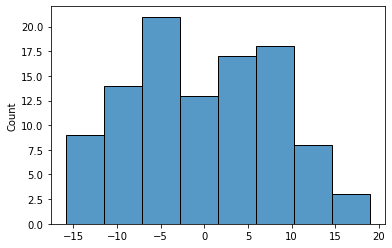

In [5]:
import seaborn as sns
sns.histplot(model_result.resid);

In [6]:
from scipy import stats
mu, std = stats.norm.fit(model_result.resid)
mu, std

(-1.283116008265812e-14, 8.418278511304978)

We can now re-plot the residuals as a kernel density plot and overlay the normal curve with the same mean and standard deviation:

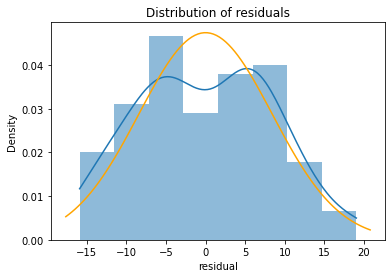

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model_result.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

## Boxplot of residuals
A boxplot is often better when the residuals are highly non-normal.  Here we see a reasonable distribution with the mean close to the median (indicating symmetry).

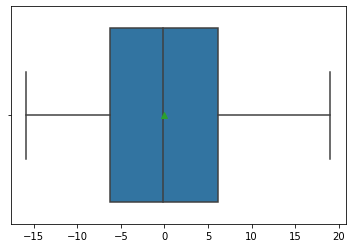

In [12]:
sns.boxplot(x=model_result.resid, showmeans=True);

## Q-Q plot

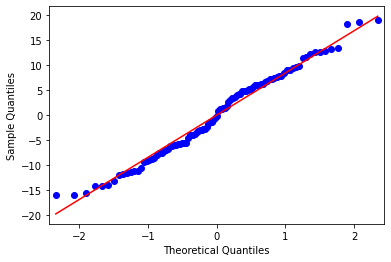

In [13]:
sm.qqplot(model_result.resid, line='s');

## Fit plot
A fit plot shows predicted values of the response variable versus actual values of _Y_.  If the linear regression model is perfect, the predicted values will exactly equal the observed values and all the data points in a predicted versus actual scatterplot will fall on the 45&deg; diagonal.



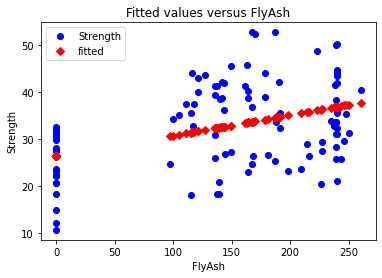

In [14]:
sm.graphics.plot_fit(model_result,1, vlines=False);

## Fit plot in seaborn
As in R, creating a better fit plot is a bit more work.  The central issue is that the observed and predicted axis must be identical for the reference line to be 45&deg;.  To achieve this, I do the following below:
1. Determine the min and max values for the observed values of _Y_
2. Predict values of _Y_
3. Create a plot showing the observed versus predicted values of _Y_. Save this to an object (in my case `ax`)
4. Modify the chart object so that the two axes share the same minimum and maximum values
5. Generate data on a 45&deg; line and add the reference line to the plot

In [15]:
model_result.fittedvalues

0      30.901424
1      34.689565
2      34.689565
3      34.645517
4      32.619302
         ...    
98     36.808282
99     36.843520
100    36.830306
101    36.843520
102    36.103511
Length: 103, dtype: float64

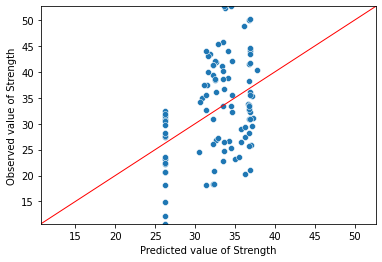

In [18]:
Y_max = Y.max()
Y_min = Y.min()

ax = sns.scatterplot(x=model_result.fittedvalues, y=Y)
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Predicted value of Strength")
ax.set_ylabel("Observed value of Strength")

X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()